# Environment Setting

In [1]:
import scanpy as sc
import scgen

# Loading Train Data

In [10]:
train = sc.read("../processedData/alldata.obj/bbknn-completed.h5ad")

We need two observation labels “batch” and “cell_type” for our batch_removal procedure. There exist a “batch” obs but no “cell_type”, so we add it as a .obs of adata

In [11]:
sc.pp.neighbors(train)
sc.tl.umap(train)

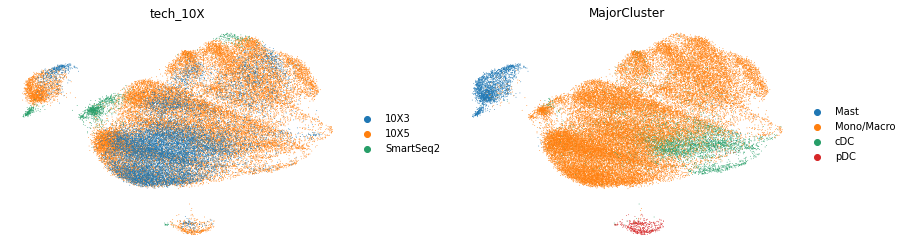

In [12]:
sc.pl.umap(train, color=["tech_10X", "MajorCluster"], wspace=.2, frameon=False)

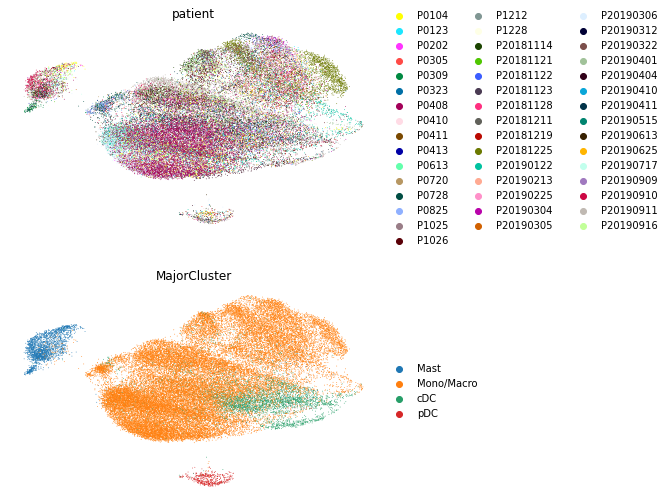

In [13]:
sc.pl.umap(train, color=["patient", "MajorCluster"], wspace=.2, frameon=False, ncols=1)

# Preprocessing Data

In [14]:
train = scgen.setup_anndata(train, batch_key="tech_10X", labels_key="MajorCluster",  copy=True)

INFO     Using batches from adata.obs["tech_10X"]                                            
INFO     Using labels from adata.obs["MajorCluster"]                                         
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/home/data/vip8t02/anaconda3/envs/scgen-2.0.0/lib/python3.9/site-packages/scvi/data/_utils.py:22: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  warnings.warn(


INFO     Successfully registered anndata object containing 45251 cells, 1999 vars, 3 batches,
         4 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Creating and Saving the model

In [15]:
model = scgen.SCGEN(train)

/home/data/vip8t02/anaconda3/envs/scgen-2.0.0/lib/python3.9/site-packages/scvi/model/base/_base_model.py:149: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [16]:
model.train(
    max_epochs=100,
    early_stopping=True,
    early_stopping_patience=25,
    use_gpu=False
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 29/100:  29%|██▉       | 29/100 [05:11<12:41, 10.73s/it, loss=140, v_num=1]


Batch-Removal

In [17]:
corrected_adata = model.batch_removal()
corrected_adata

/home/data/vip8t02/anaconda3/envs/scgen-2.0.0/lib/python3.9/site-packages/scvi/model/base/_base_model.py:149: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/home/data/vip8t02/anaconda3/envs/scgen-2.0.0/lib/python3.9/site-packages/scvi/data/_utils.py:22: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  warnings.warn(


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 45251 cells, 1999 vars, 3 batches,
         4 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


AnnData object with n_obs × n_vars = 45251 × 1999
    obs: 'patient', 'tissue', 'percent_hsp', 'percent_mito', 'n_genes', 'n_counts', 'Sub_Cluster', 'tech', 'cancer', 'tech_10X', 'MajorCluster', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    uns: '_scvi'
    obsm: 'latent', 'corrected_latent'

# Visualization of the corrected gene expression data

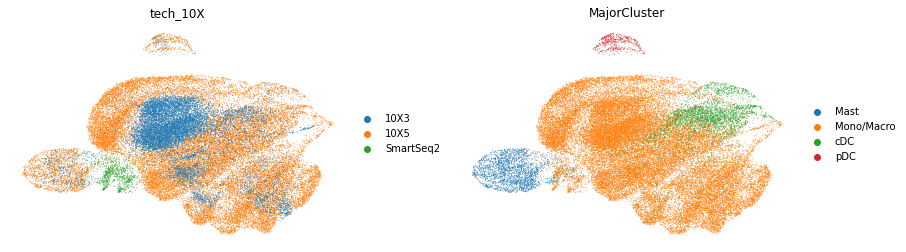

In [37]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)
sc.pl.umap(corrected_adata, color=['tech_10X', 'MajorCluster'], wspace=0.2, frameon=False)

Use low-dim corrected gene expression data

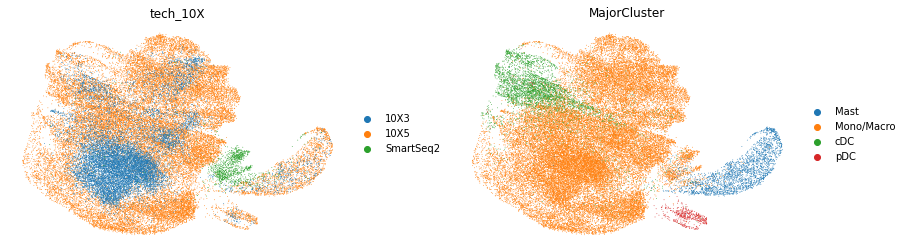

In [20]:
sc.pp.neighbors(corrected_adata, use_rep="corrected_latent")
sc.tl.umap(corrected_adata)
sc.pl.umap(corrected_adata, color=['tech_10X', 'MajorCluster'], wspace=0.2, frameon=False)

In [38]:
corrected_adata

AnnData object with n_obs × n_vars = 45251 × 1999
    obs: 'patient', 'tissue', 'percent_hsp', 'percent_mito', 'n_genes', 'n_counts', 'Sub_Cluster', 'tech', 'cancer', 'tech_10X', 'MajorCluster', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    uns: '_scvi', 'neighbors', 'umap', 'tech_10X_colors', 'MajorCluster_colors'
    obsm: 'latent', 'corrected_latent', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [39]:
corrected_adata.obsm['X_umap']

array([[18.274294 ,  3.709844 ],
       [ 6.5724707, -1.5245486],
       [ 5.23538  , -1.7476333],
       ...,
       [ 4.101913 , -2.9684124],
       [ 4.428085 , -3.6813755],
       [14.287989 , -3.7950954]], dtype=float32)

In [40]:
import numpy as np
import pandas as pd

dat = corrected_adata.obsm['X_umap']
mat = np.random.randn(45251,2)
scgen = pd.DataFrame(mat,columns=['umap_1','umap_2'])
scgen

,umap_1,umap_2
0,-0.151589,1.615133
1,0.725352,0.570313
2,-0.686380,-0.785905
3,-0.195234,0.450265
4,0.750772,0.661625
...,...,...
45246,1.106200,-0.581278
45247,0.267249,-1.563446
45248,-1.946226,0.423363
45249,-0.206053,1.258821


In [41]:
scgen.to_csv('../processedData/alldata.obj/scgen-data-umap.csv')